## Description of the project.
Let's imagine mobile application that receives traffic from different sources. This traffic is not homogeneous and we need to know it better in order to optimize marketing activity

Your task is to analyze dataset in order to find useful insights: what segments of data bring traffic with the best quality (Main metric is conversion rate from lead to client. There can be other metrics as well) 


You can do this by answering following questions:
- How users are distributed over countries?
- How many outliers are there in data (in terms of deposits)?
- Find segments with best conversion rate (client/lead ratio) and explain why you consider them best ones
- Visualize deposits distribution over sources and channels
- What are your advices to marketing team in order to optimize their activity?

To do this you have a synthetic dataset that contains history of users' activities (registrations and deposits)

Data description: client_id - unique id of lead/client. it's assigned during registration and isn't changed anymore 

- Country - country of lead/client (iso2). It's in the separate file (countries.csv)

- Source - source of traffic acquisition. There are two possible sources (posts and telegram channel). if Source contains "postid" - it means that lead came from article. id of post doesn't matter. if Source contains "telegram" - it means that lead came from telegram 

- channel - channel of traffic. For example, user can come from 'telegram' source and from 'affiliate' channel

- Clicks - amount of clicks user made during first day after registration

- Latency - time of application loading in miliseconds

- Depo - amount of deposit, USD

Expected result is Jupyter notebook with Python code showing answers to questions above

Glossary:
- Lead: user who registered inside mobile app
- Client: user who registered inside mobile app AND made a deposit

---

### 1. Let's prepare data for analysis

In [564]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
import matplotlib.gridspec as grid_spec
import matplotlib as mpl

from scipy import stats as st

In [418]:
countries = pd.read_csv('countries.csv')
data = pd.read_csv('synthetic_data.csv', index_col = 0)

#### 1.1. Check for duplicates

In [419]:
print(f"Duplicates in countries: {countries.duplicated().sum()}")
print(f"Duplicates in data: {data.duplicated().sum()}")

Duplicates in countries: 61754
Duplicates in data: 0


As dataset *countries* only represents the country of a certain user, we can get rid of duplicates in this dataframe.

In [420]:
# getting rid of duplicates and updating the index
countries = countries.drop_duplicates().reset_index(drop = True)

#### 1.1. Check for NaN values

In [421]:
print("NaN values in countries:",countries.isna().sum(), sep = '\n\n', end = '\n\n')
print("NaN values in data:",data.isna().sum(), sep = '\n\n')

NaN values in countries:

country      0
client_id    0
dtype: int64

NaN values in data:

depo            0
segment         0
channel      2172
clicks          0
latency         0
client_id       0
dtype: int64


Let's look closer at the *channel* column.

In [422]:
# checking the percentage of NaN values in dataset

len(data[data['channel'].isna() == True]['channel']) / len(data) * 100

0.9903608524763581

As we can see, the NaN values in *channel* represent 1% of the total. Let's get rid of NaN values then.

In [423]:
data = data[data['channel'].isna() != True]

In [424]:
# check one more time if everything's clear

print("NaN values in data:",data.isna().sum(), sep = '\n\n')

NaN values in data:

depo         0
segment      0
channel      0
clicks       0
latency      0
client_id    0
dtype: int64


#### 1.3. Check for abnormal quantitative values

***We have some columns with quantitative values to check if they're okay.***

1. Latency
2. Clicks
3. Depo

I'll use a boxplot and .describe() method to make sure we don't have any "bad" values.

##### 1.3.1. Latency

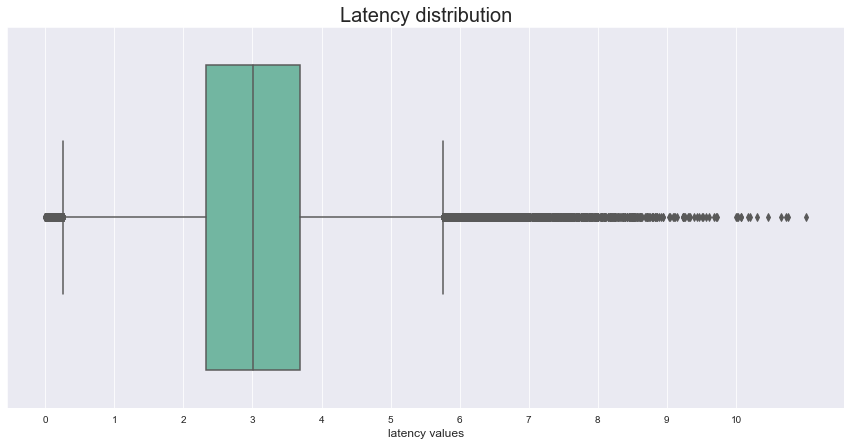

count    217142.000000
mean          3.021538
std           1.048373
min           0.000071
25%           2.320726
50%           3.001292
75%           3.693413
95%           4.727578
99%           5.627120
max          11.016521
Name: latency, dtype: float64

In [425]:
sns.set_style('darkgrid')
plt.figure(figsize = (15,7))

plt.title('Latency distribution', size = 20)
sns.boxplot(data['latency'], palette = 'Set2')
plt.xticks(range(0,11,1), size = 10)
plt.xlabel('latency values', size = 12)

plt.show()

data['latency'].describe(percentiles = [.25, .50, .75, .95, .99])

***Latency column is pretty sure normal, all values are okay.***

##### 1.3.2. Clicks

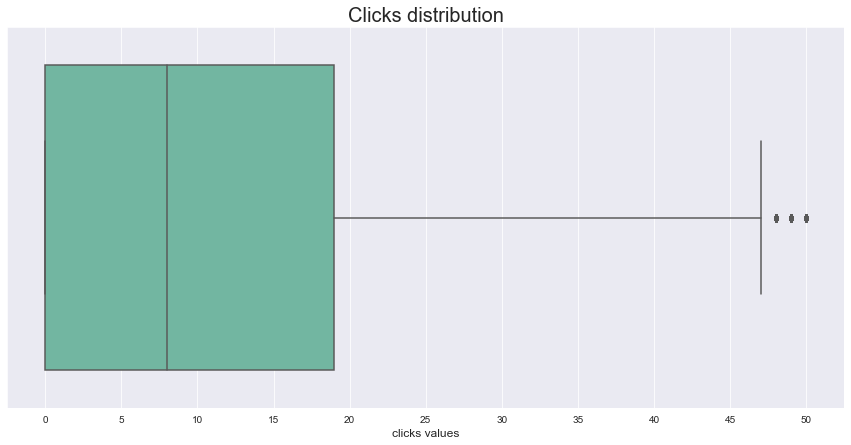

count    217142.000000
mean         11.426265
std          12.627325
min           0.000000
25%           0.000000
50%           8.000000
75%          19.000000
95%          37.000000
99%          47.000000
max          50.000000
Name: clicks, dtype: float64

In [426]:
sns.set_style('darkgrid')
plt.figure(figsize = (15,7))

plt.title('Clicks distribution', size = 20)
sns.boxplot(data['clicks'], palette = 'Set2')
plt.xticks(range(0,51,5), size = 10)
plt.xlabel('clicks values', size = 12)

plt.show()

data['clicks'].describe(percentiles = [.25, .50, .75, .95, .99])

***Clicks column is pretty sure normal, all values are okay.***

##### 1.3.3. Depo

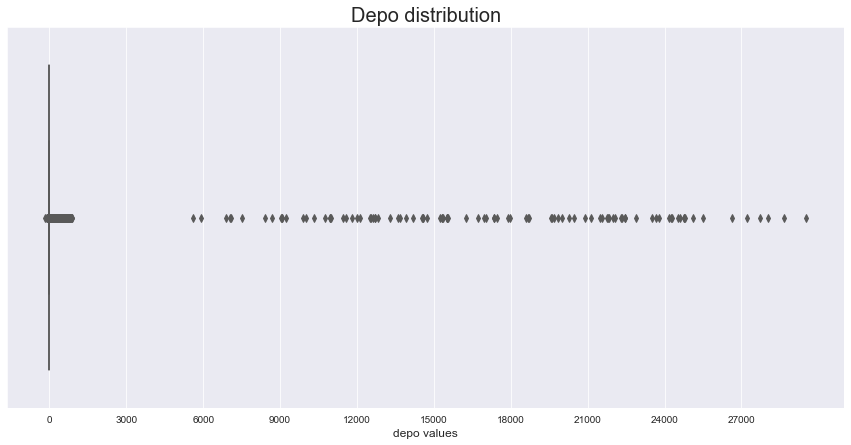

count    217142.000000
mean         22.305404
std         393.942517
min        -164.000000
25%           0.000000
50%           0.000000
75%           0.000000
95%           0.000000
99%         446.000000
max       29527.000000
Name: depo, dtype: float64

In [427]:
sns.set_style('darkgrid')
plt.figure(figsize = (15,7))

plt.title('Depo distribution', size = 20)
sns.boxplot(data['depo'], palette = 'Set2')
plt.xticks(range(0,30000,3000), size = 10)
plt.xlabel('depo values', size = 12)

plt.show()

data['depo'].describe(percentiles = [.25, .50, .75, .95, .99])

***We can see that we got some negative values in depo column.***

Obviously deposit can't be negative, so let's get rid of these values and move further.

In [428]:
data = data.query('depo >= 0')

### 2. Answering the questions



>Our main metric is ***CR from lead to client***. I'll make EDA based on this principle.

### 2.1. How users are distributed over countries?

In [429]:
countries1 = countries.pivot_table(index = 'country', values = 'client_id', aggfunc = 'count')
countries1['country'] = countries1.index
countries1 = countries1.reset_index(drop = True).sort_values(by = 'client_id', ascending = False)

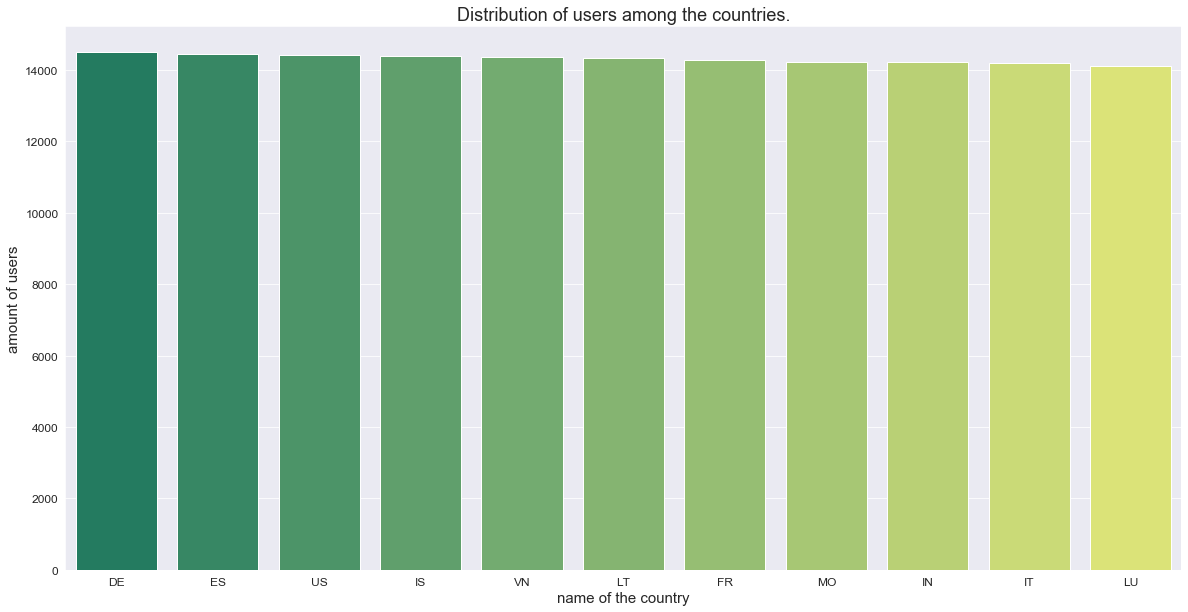

In [430]:
plt.figure(figsize = (20,10))

plt.title('Distribution of users among the countries.', size = 18)

sns.barplot(data = countries1, x = 'country', y = 'client_id', palette = 'summer')

plt.xlabel('name of the country', size = 15)
plt.ylabel('amount of users', size = 15)

plt.xticks(size = 12)
plt.yticks(size = 12)

plt.show()

*There's almost the same amount of users in every country, about 14-15k in each of them.*

**Now let's look separately at countries with leads and clients.**

In [431]:
# merging the countries dataset with data (tbh it'd be better to do this at the beginning, but i forgot :( )

data = data.merge(countries, how = 'left', on = 'client_id')

In [432]:
#creating 2 new dataframes to separate leads and clients

leads = data.query('depo == 0')
clients = data.query('depo != 0')

In [433]:
country_leads = leads.pivot_table(index = 'country', values = 'client_id', aggfunc = 'count')
country_leads['country'] = country_leads.index
country_leads = country_leads.reset_index(drop = True).sort_values(by = 'client_id', ascending = False)

In [434]:
country_clients = clients.pivot_table(index = 'country', values = 'client_id', aggfunc = 'count')
country_clients['country'] = country_clients.index
country_clients = country_clients.reset_index(drop = True).sort_values(by = 'client_id', ascending = False)

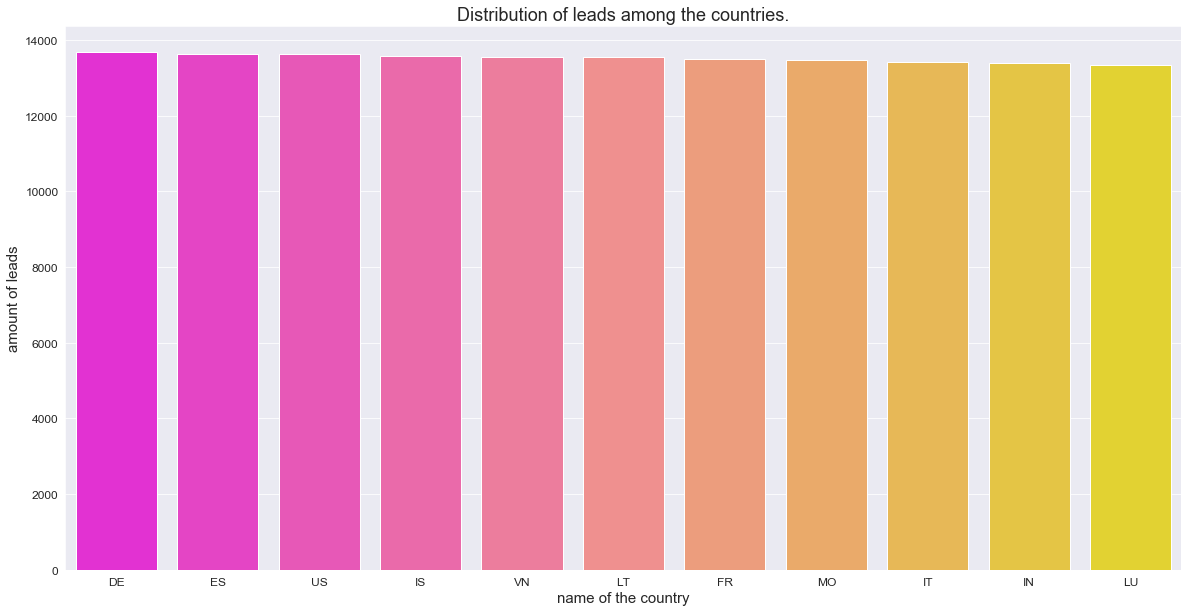

In [435]:
plt.figure(figsize = (20,10))

plt.title('Distribution of leads among the countries.', size = 18)

sns.barplot(data = country_leads, x = 'country', y = 'client_id', palette = 'spring')
plt.xlabel('name of the country', size = 15)
plt.ylabel('amount of leads', size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)

plt.show()

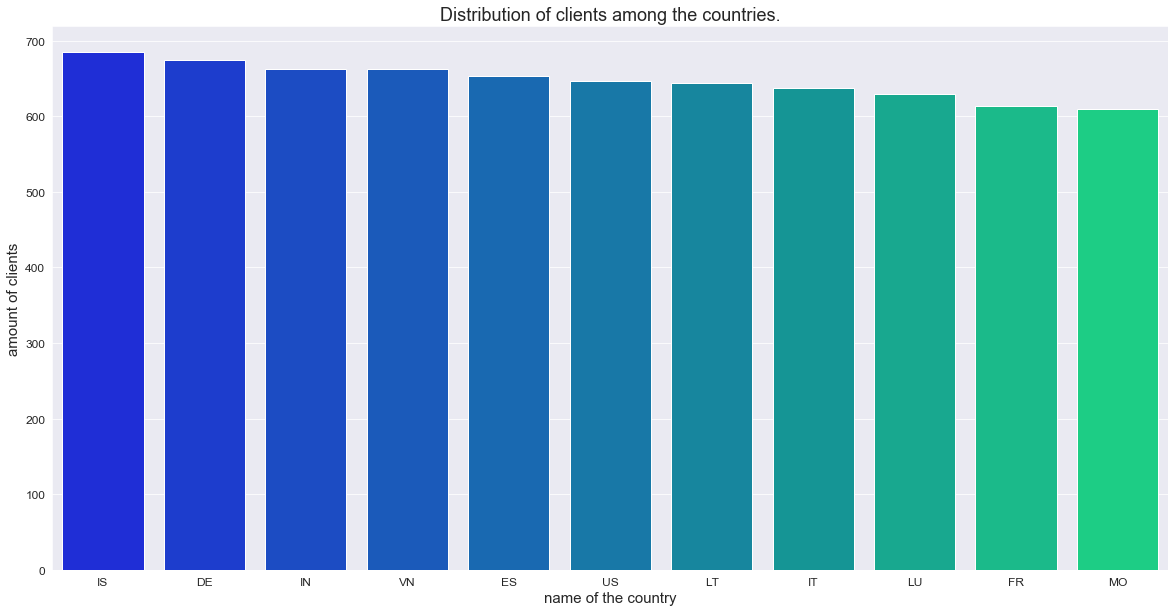

In [436]:
plt.figure(figsize = (20,10))

plt.title('Distribution of clients among the countries.', size = 18)

sns.barplot(data = country_clients, x = 'country', y = 'client_id', palette = 'winter')
plt.xlabel('name of the country', size = 15)
plt.ylabel('amount of clients', size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)

plt.show()

***Almost no difference as well, now let's see at CR in every country.***

In [437]:
country_leads = country_leads.rename(columns = {'client_id' : 'leads_amount'})
country_clients = country_clients.rename(columns = {'client_id' : 'clients_amount'})

In [438]:
q1 = country_leads.merge(country_clients, how = 'outer', on = 'country')
q1['CR'] = q1['clients_amount'] / q1['leads_amount']
q1 = q1.sort_values(by = 'CR', ascending = False)

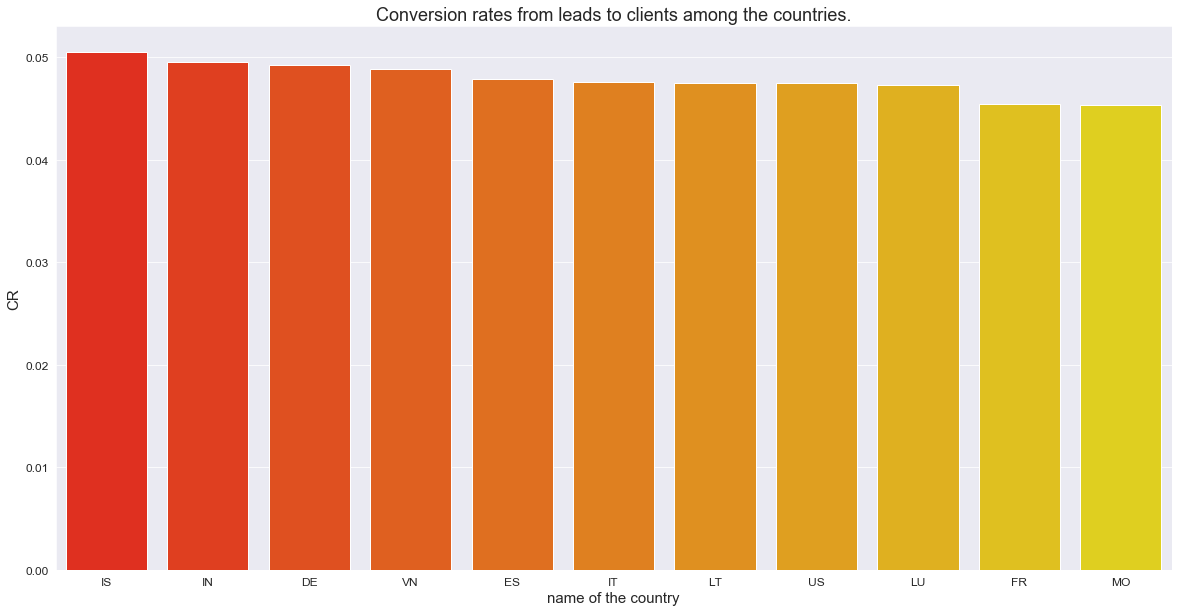

In [439]:
plt.figure(figsize = (20,10))

plt.title('Conversion rates from leads to clients among the countries.', size = 18)

sns.barplot(data = q1, x = 'country', y = 'CR', palette = 'autumn')
plt.xlabel('name of the country', size = 15)
plt.ylabel('CR', size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)

plt.show()

***Answer | Question 1:***

CR from lead to client absolutely does not depend on the country.

### 2.2. How many outliers are there in data (in terms of deposits)?

To give an answer to this question, I will use boxplot and  `.describe()` method.

I will not include depo == 0, as we have majority of them, let's analyze clients only.

In [440]:
q2 = data.query('depo != 0')

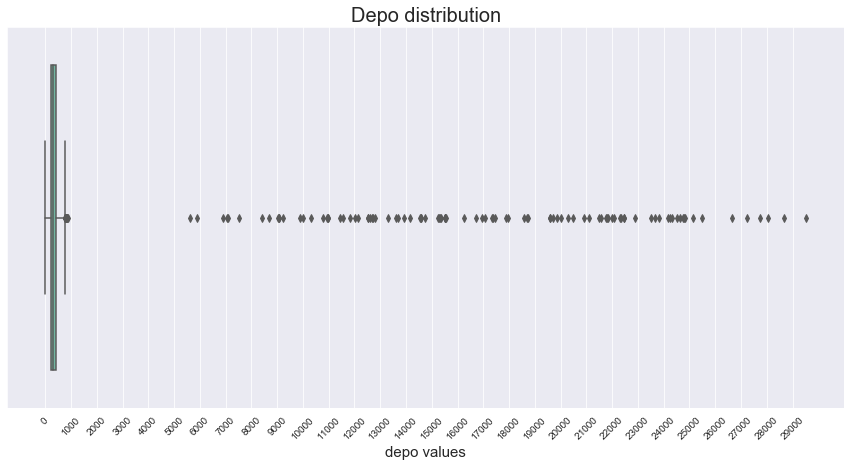

count     9898.000000
mean       489.667509
std       1782.132390
min          1.000000
25%        214.000000
50%        321.000000
75%        430.000000
95%        580.000000
99%       1018.170000
max      29527.000000
Name: depo, dtype: float64

In [441]:
sns.set_style('darkgrid')
plt.figure(figsize = (15,7))

plt.title('Depo distribution', size = 20)
sns.boxplot(q2['depo'], palette = 'Set2')
plt.xticks(range(0,30000,1000), size = 10, rotation = 45)
plt.xlabel('depo values', size = 15)

plt.show()

q2['depo'].describe(percentiles = [.25, .50, .75, .95, .99])

As we can see from boxplot above, the outliers start from 1000, so let's calculate the percent of outliers.

In [442]:
outliers_percent = q2.query('depo >= 1000')['depo'].count() / q2.query('depo < 1000')['depo'].count() * 100
print(outliers_percent)

1.010307174201449


***Answer | Question 2:***

Percent of outliers is 1.01%.

### 2.3. Find segments with best conversion rate (client/lead ratio) and explain why you consider them best ones

***Reading from description:***
> There are two possible sources (posts and telegram channel). if Source contains "postid" - it means that lead came from article. id of post doesn't matter. if Source contains "telegram" - it means that lead came from telegram 

Let's rename *postid* values to *arcticle*.

In [446]:
# works slow, wait a bit please!!!

articles = []

for element in data['segment']:
    if element != 'telegram' and element not in articles:
        articles.append(element)

In [452]:
# works slow as well, so wait!!!

for element in articles:
    data.loc[data['segment'] == element, 'segment'] = 'article'

Now let's calculate amount of users and all related stuff.

In [461]:
leads = data.query('depo == 0')
clients = data.query('depo != 0')

In [466]:
segment_leads = leads.pivot_table(index = 'segment', values = 'client_id', aggfunc = 'count')
segment_clients = clients.pivot_table(index = 'segment', values = 'client_id', aggfunc = 'count')

In [467]:
segment_leads = segment_leads.rename(columns = {'client_id' : 'leads_amount'})
segment_clients = segment_clients.rename(columns = {'client_id' : 'clients_amount'})

In [484]:
q3 = segment_leads.merge(segment_clients, how = 'outer', on = 'segment')
q3['CR'] = q3['clients_amount'] / q3['leads_amount']
q3 = q3.sort_values(by = 'CR', ascending = False)

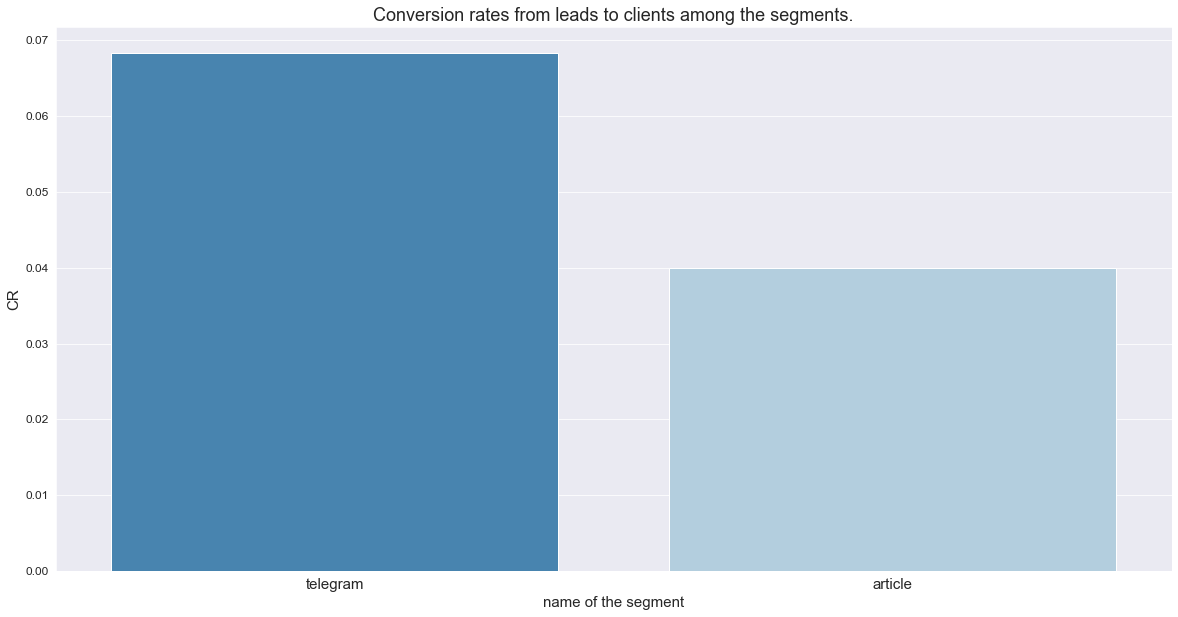

In [488]:
plt.figure(figsize = (20,10))

plt.title('Conversion rates from leads to clients among the segments.', size = 18)

sns.barplot(data = q3, x = q3.index, y = 'CR', palette = 'Blues_r')
plt.xlabel('name of the segment', size = 15)
plt.ylabel('CR', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 12)

plt.show()

***Answer | Question 3***:
The best segment is telegram, it has almost 7% CR while arcticle has only 3%. I think the marketing company should focus on telegram more as it brings rather more traffic than articles do. (full insight will be in separated "insights section" later)

### 2.4. Visualize deposits distribution over sources and channels

I'll start with sources (segments).

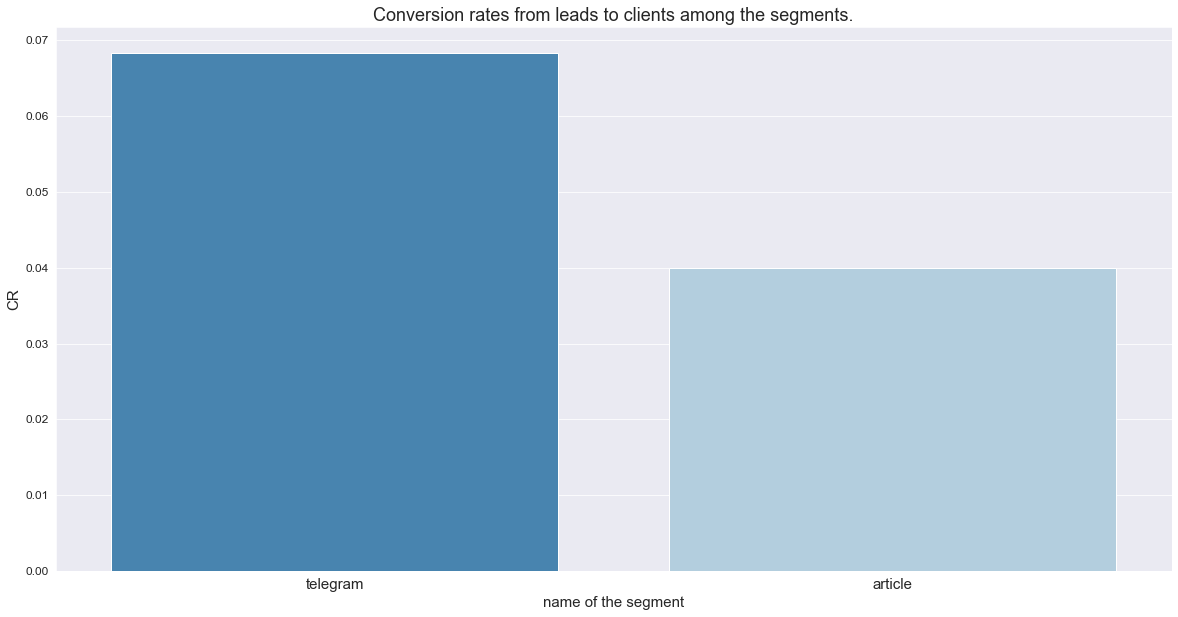

In [606]:
plt.figure(figsize = (20,10))

plt.title('Conversion rates from leads to clients among the segments.', size = 18)

sns.barplot(data = q3, x = q3.index, y = 'CR', palette = 'Blues_r')
plt.xlabel('name of the segment', size = 15)
plt.ylabel('CR', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 12)

plt.show()

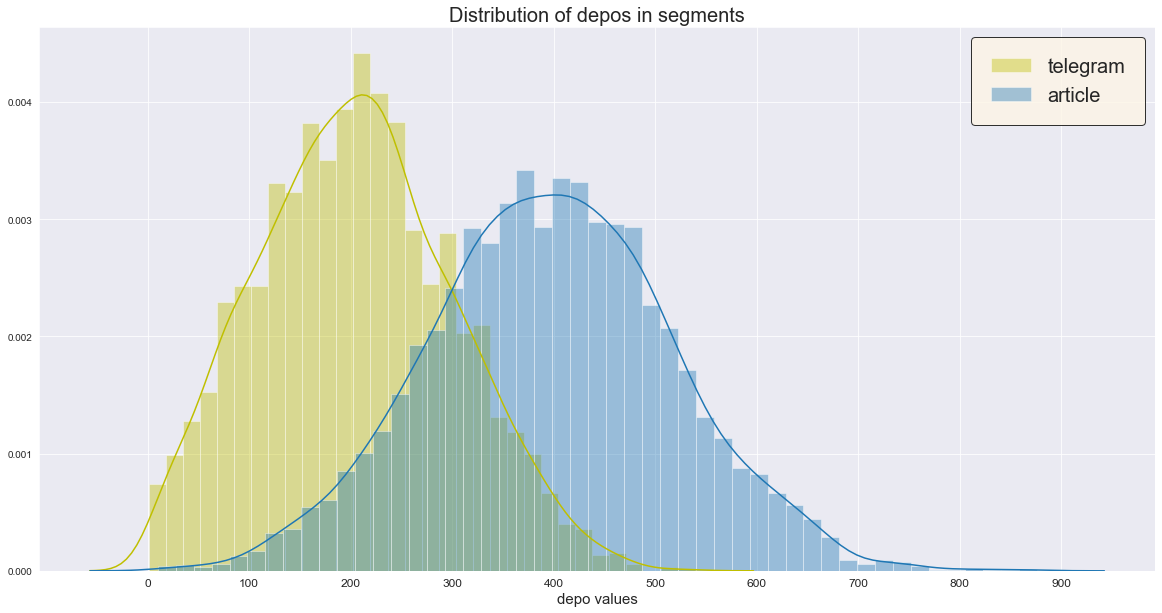

In [607]:
plt.figure(figsize = (20,10))

plt.title('Distribution of depos in segments', size = 20)

sns.distplot(clients.query('segment == "telegram" and depo < 1000')['depo'], color = 'y', label = 'telegram')
sns.distplot(clients.query('segment == "article" and depo < 1000')['depo'], label = 'article')

plt.xticks(range(0,1000, 100), size = 12)
plt.xlabel('depo values', size = 15)

plt.legend(shadow = False,
           fontsize = 20,
           facecolor = 'oldlace',
           edgecolor = 'black',
           borderpad=1) 

plt.show()

*Even though article does not have that good CR as telegram has, but it brings more money and customers tend to pay more.*

Now let's deal with channels. I want to look at CR first and then show distributions.

In [614]:
channel_leads = leads.pivot_table(index = 'channel', values = 'client_id', aggfunc = 'count')
channel_clients = clients.pivot_table(index = 'channel', values = 'client_id', aggfunc = 'count')

In [615]:
channel_leads = channel_leads.rename(columns = {'client_id' : 'leads_amount'})
channel_clients = channel_clients.rename(columns = {'client_id' : 'clients_amount'})

In [616]:
q4 = channel_leads.merge(channel_clients, how = 'outer', on = 'channel')
q4['CR'] = q4['clients_amount'] / q4['leads_amount']
q4 = q4.sort_values(by = 'CR', ascending = False)

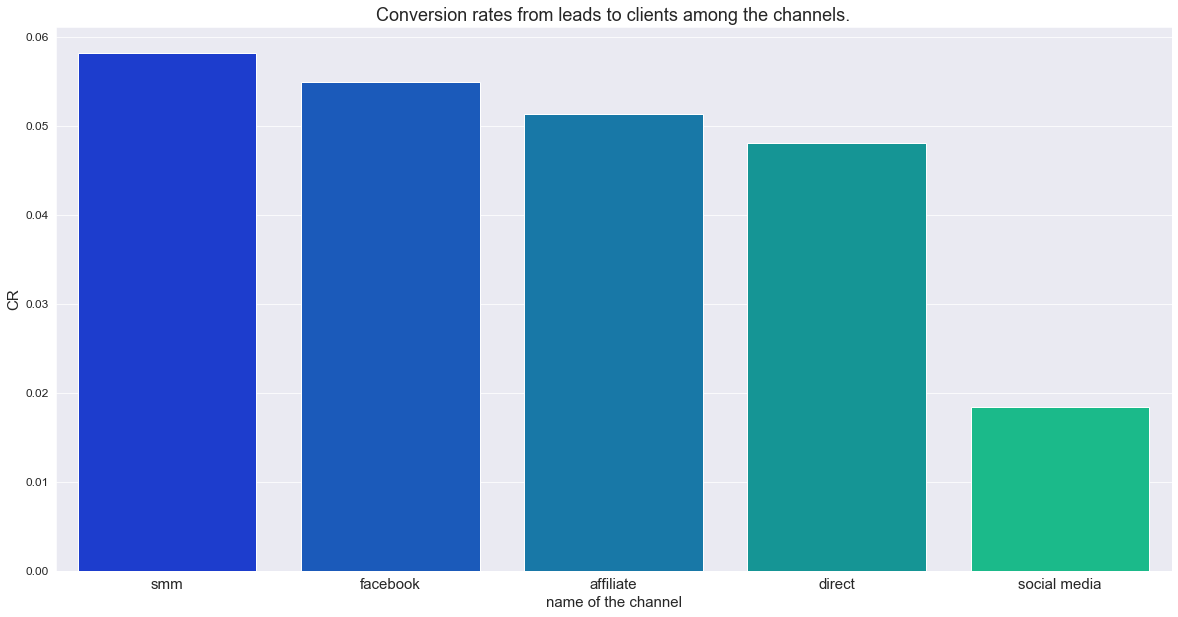

In [630]:
plt.figure(figsize = (20,10))

plt.title('Conversion rates from leads to clients among the channels.', size = 18)

sns.barplot(data = q4, x = q4.index, y = 'CR', palette = 'winter')
plt.xlabel('name of the channel', size = 15)
plt.ylabel('CR', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 12)

plt.show()

In [588]:
print(f"List of channels: \n{list(clients['channel'].unique())}")

channels = list(clients['channel'].unique())
temp = clients.query('depo < 1000')

List of channels: 
['smm', 'direct', 'facebook', 'social media', 'affiliate']


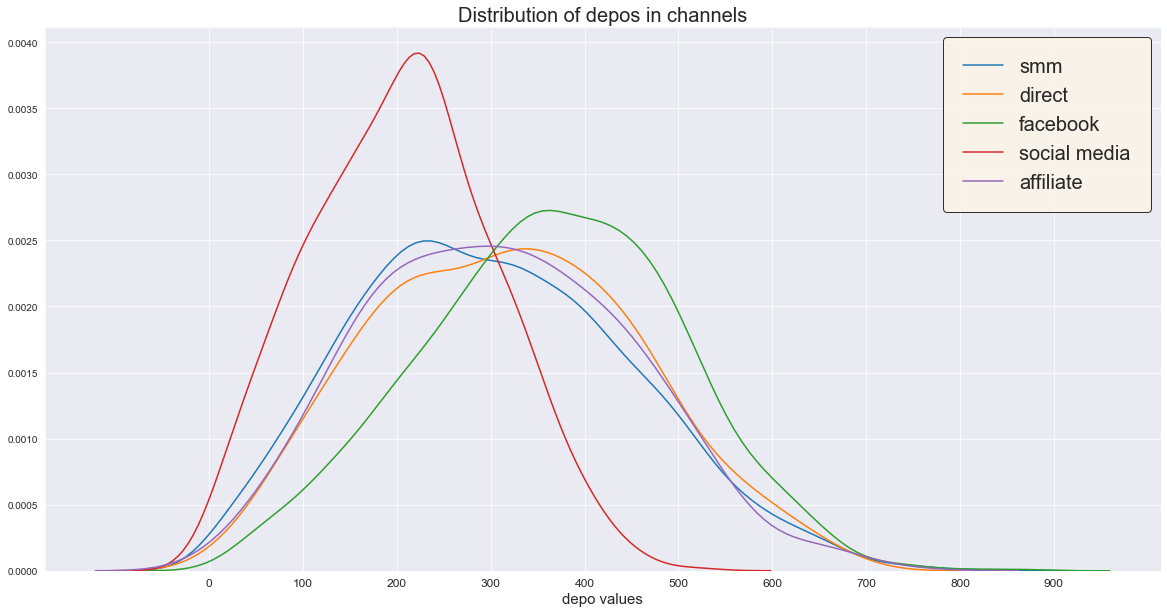

In [599]:
plt.figure(figsize = (20,10))

plt.title('Distribution of depos in channels', size = 20)

for channel in channels:
    sns.distplot(temp.query('channel == @channel')['depo'], label = channel, hist = False)
    
    
plt.xticks(range(0,1000, 100), size = 12)
plt.xlabel('depo values', size = 15)
    
plt.legend(shadow = False,
           fontsize = 20,
           facecolor = 'oldlace',
           edgecolor = 'black',
           borderpad=1) 


plt.show()

***Some conclusions:***
1. Social media bring less money than other channels and it has the lowest CR.
2. SMM, direct, facebook and affiliate functionalize pretty well, besides client's from facebook bring a bit more money.

---

## What are your advices to marketing team in order to optimize their activity?

During EDA, I came up to conclusion that country of client and latency do NOT depend on CR. Now I want to calculate final metric and give all the insights down below.

In [652]:
# calculating CR within segments and channels

qq_leads = leads.groupby(['segment', 'channel'])['client_id'].count()
qq_clients = clients.groupby(['segment', 'channel'])['client_id'].count()

qq_clients / qq_leads * 100

segment   channel     
article   affiliate        3.986135
          direct           4.048826
          facebook         6.260121
          smm              4.004622
          social media          NaN
telegram  affiliate        8.191489
          direct           6.824147
          facebook         3.512015
          smm             10.596606
          social media     6.672497
Name: client_id, dtype: float64

### Advices:
1. Articles bring more clients than telegram and clients from articles also usually pay more than telegram, but telegram has way better Conversion Rates. *So I recommend to focus on quality of posts/marketing in articles to get better CR, and focus on telegram with simple goal - attract audience that will pay more money.*

2. `Social media` channel is so poor. I'd give a piece of advice to either get rid of it completely and focus on other channels of marketing or try to look at `social media` channel more closely to find out why, and review marketing strategy for social media.

3. `Facebook` has the highest conversion rate in article, but the lowest in telegram, so I'd honestly cut `Facebook` from telegram completely and focus all `Facebook` traffic on articles. People either use `telegram` or `Facebook`, rarely both of them.

4. `direct`, `smm` work pretty well everywhere, there should be no changes.

5. `affiliate` shows really great results on telegram side, but not that bright on article's one. I think `affiliate` should be optimized towards article.

6. CR does not depend on country or it does, but the current marketing strategy is good enough to split it equally among all the countries, do don't change marketing strategy regarding countries.

*Made by Pavel Paramonov*